# PCB Defect Image Extraction

### Install tetryonai

In [0]:
!pip install git+https://github.com/sean-mcclure/tetryon_ai.git

In [0]:
from tetryonai.main import *

###Make the following folders:

*   difference_img
*   extracted_defects
*   hold_out 

In [0]:
directory(**{
    "choice" : "make",
    "directory_path" : "difference_img"
})

directory(**{
    "choice" : "make",
    "directory_path" : "extracted_defects"
})

directory(**{
    "choice" : "make",
    "directory_path" : "hold_out"
})

###Clone PCB Dataset

In [4]:
!git clone https://github.com/tangsanli5201/DeepPCB.git

Cloning into 'DeepPCB'...
remote: Enumerating objects: 4753, done.
remote: Total 4753 (delta 0), reused 0 (delta 0), pack-reused 4753
Receiving objects: 100% (4753/4753), 85.81 MiB | 37.20 MiB/s, done.
Resolving deltas: 100% (191/191), done.


### Read in PCB Defect Images (temp and test)

In [0]:
import glob

image_path = 'DeepPCB/PCBData/'
temp_pattern = '/*temp.jpg'
test_pattern = '/*test.jpg'

temps_and_tests = {}

for folder in os.listdir(image_path):
    full_path = image_path + folder + '/' + folder.replace('group', '')
    temps = glob.glob(full_path + '/' + temp_pattern)
    tests = glob.glob(full_path + '/' + test_pattern)
    inner = {}
    inner['temps'] = temps
    inner['tests'] = tests
    temps_and_tests[folder] = inner

### Create Hold Out Dataset with 20% test/temp images, and difference the rest

In [0]:
split_percentage = round(len(temps_and_tests['group00041']['temps']) * 0.2)

for index, whatever in enumerate(temps_and_tests['group00041']['temps']):
    root_img_name = temps_and_tests['group00041']['temps'][index].replace('_temp.jpg', '')
    temp_file_path = root_img_name  + '_temp.jpg'
    test_file_path = root_img_name + '_test.jpg'
    if(index < split_percentage):
      copy_files(**{
          "file_paths" : [temp_file_path],
          "target_directory" : "hold_out/"
      })
      copy_files(**{
          "file_paths" : [test_file_path],
          "target_directory" : "hold_out/"
      })
    else:
      subtract_images(**{
          "image_path_1" : temp_file_path,
          "image_path_2" : test_file_path,
          "write_path" : "difference_img/diff_image_" + str(index) + ".png"
      })

### Extract the defects from all differenced images

In [0]:
all_differenced_images = os.listdir('difference_img')

In [0]:
for index, filename in enumerate(all_differenced_images):
    os.mkdir("extracted_defects/extracts_" + str(index))
    this_write_path = "extracted_defects/extracts_" + str(index) + "/"
    extract_contours_from_image(**{
        "image_path" : "difference_img/" + filename,
        "write_path" : this_write_path,
        "hsv_lower" : [0,150,50],
        "hsv_upper" : [10,255,255]
    })

### Combine extracted images into single directory

In [0]:
directory(**{
    "choice" : "make",
    "directory_path" : "all_extracts"
})

In [0]:
cnt=0
for dirpath, dirs, files in os.walk("extracted_defects"):
    for index, filename in enumerate(files):
        if filename.endswith(".png"):
            cnt += 1            
            move_files(**{
                "file_paths" : [dirpath + "/" + filename],
                "target_directory" : "all_extracts/extract_" + str(cnt) + ".png"
            })

### Zip all extracted defect images 
#### Use for labelling in Defect Turker

In [0]:
!zip -r /content/extracted_defects.zip /content/all_extracts/

### Create JSON file for defect turker

In [0]:
import json

file_names_and_sizes = {}
file_names = os.listdir('all_extracts/')

for index, file in enumerate(file_names):
  file_names_and_sizes[file_names[index]] = os.path.getsize('all_extracts/' + file)

### Remove any image paths with sizes 0
#### Already taken care of by using tetryonai's contour function, but keeping here for others to use if needed

In [0]:
file_names_and_sizes = {k: v for k, v in file_names_and_sizes.items() if v != 0}

### Save JSON to Disk for Uploading to Defect Turker

In [0]:
with open('extracted_defects.json', 'w') as outfile:
    json.dump(file_names_and_sizes, outfile)

# PCB Defect Classification

##Install FASTAI

In [0]:
!pip install http://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip install fastai

In [0]:
from fastai.vision import *

### Upload labelled data (CSV file)

In [0]:
from google.colab import files
files.upload()

### Convert labelled data CSV to dataframe

In [0]:
image_labels_frame = csv_to_dataframe(**{
    "path_to_csv" : "image_labels.csv"
})

### Check Class Balance

In [0]:
labelled_counts = get_feature_counts(**{
    "data_frame" : image_labels_frame, 
    "feature" : "label"
})

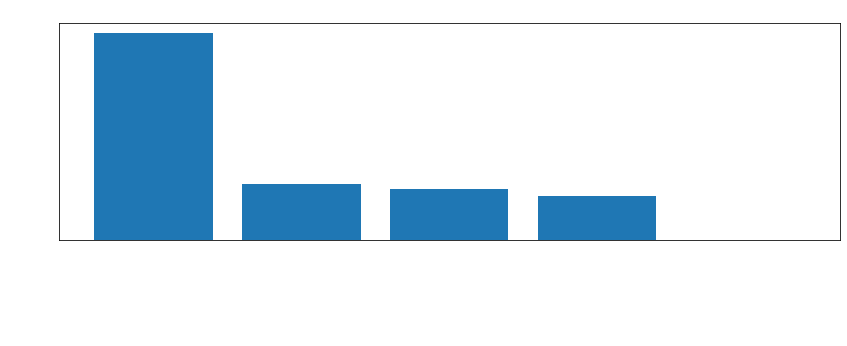

In [21]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 4
rcParams['text.color'] = "white"
rcParams['axes.labelcolor'] = "white"
rcParams['xtick.color'] = "white"
rcParams['ytick.color'] = "white"

index = np.arange(len(labelled_counts.keys()))
plt.bar(index, list(labelled_counts.values()))
plt.xlabel('Defect Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(index, labelled_counts.keys(), fontsize=5, rotation=30)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Defect Class Balance')
plt.show()

### Create new directory for training CSVs

In [0]:
directory(**{
    "choice" : "make",
    "directory_path" : "training_csvs"
})

### Create individual CSV files for each CLASS

In [0]:
spur = []
short = []
spurious = []
not_defect = []
for index, row in image_labels_frame.iterrows():
  if(row[1] == 'spur'):
    spur.append(row[0])
  if(row[1] == 'short'):
    short.append(row[0])
  if(row[1] == 'spurious copper'):
    spurious.append(row[0])
  if(row[1] == 'NOT'):
    not_defect.append(row[0])

In [0]:
df_spur = pd.DataFrame(spur)
df_spur.to_csv("spur.csv", sep=',',index=False)

df_short = pd.DataFrame(short)
df_short.to_csv("short.csv", sep=',',index=False)

df_spurious = pd.DataFrame(spurious)
df_spurious.to_csv("spurious.csv", sep=',',index=False)

df_not_defect = pd.DataFrame(not_defect)
df_not_defect.to_csv("not_defect.csv", sep=',',index=False)

### Create Directories for CSV files (needed for FastAI)

In [0]:
for folder in ['short', 'spur', 'spurious', 'not_defect']:
    directory(**{
        "choice" : "make",
        "directory_path" : "training_csvs/" + folder
    })

### Move CSV files to all_extracts directory

In [0]:
move_files(**{
    "file_paths" : ["short.csv", "spur.csv", "spurious.csv", "not_defect.csv"],
    "target_directory" : "training_csvs/"
})

### Remove extracted_defects.zip and upload the extracted_defects.zip used for labelling with the Defect Turker (while these may often be the same file, if you restarted this pipeline this will not be the case. Uploading is the safest).

In [0]:
!rm extracted_defects.zip

In [0]:
# upload extracted_defects.zip used for Defect Turker
files.upload()

### Move extracted_defects.zip into the training_csvs folder:

In [0]:
move_files(**{
    "file_paths" : ["extracted_defects.zip"],
    "target_directory" : "training_csvs"
})

### Extract all images from extracted_defects.zip into the training_csvs folder:

In [0]:
import zipfile
with zipfile.ZipFile("training_csvs/extracted_defects.zip", 'r') as zip_ref:
    zip_ref.extractall("training_csvs/")

### Move all extracted defect images into their proper training folder, using the image_labels.csv data:

In [0]:
path = "training_csvs/"
path_to_extracts = "training_csvs/content/all_extracts/"

for index, row in df_spur.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/spur/" + row[0]
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })
    
for index, row in df_short.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/short/" + row[0]
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })
    
for index, row in df_spurious.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/spurious/" + row[0]
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })

for index, row in df_not_defect.iterrows():    
    from_path = path_to_extracts + row[0]
    to_path = path + "/not_defect/" + row[0]
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })

### Remove any remaining PNG files (defect images) that were not labelled:

In [0]:
directory(**{
    "choice" : "remove",
    "directory_path" : "training_csvs/content",
    "force" : True
})

### Read in image data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4, bs=10).normalize(imagenet_stats)

### Inspect Images to Confirm Read Properly

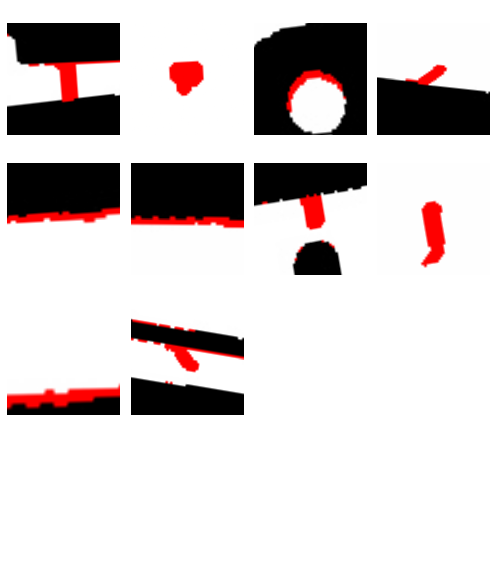

In [35]:
data.show_batch(rows=4, figsize=(7, 8))

### Train Model

In [0]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=error_rate)

### Use fit_one_cycle to change the learning rate over time (use GPU)

In [37]:
defaults.device = torch.device('cuda')
learn.fit_one_cycle(10) 

epoch,train_loss,valid_loss,error_rate,time
0,0.956796,0.433753,0.168459,06:30
1,0.603626,0.285788,0.107527,06:09
2,0.410262,0.224363,0.082437,05:59
3,0.371567,0.180483,0.053763,05:56
4,0.278483,0.248795,0.103943,05:47
5,0.319314,0.149906,0.046595,05:47
6,0.242797,0.132371,0.046595,05:47
7,0.244430,0.148013,0.046595,05:49
8,0.210949,0.119765,0.035842,05:49
9,0.167252,0.114283,0.039427,05:48


### Find better learning rates using lr_find, and use recorder.plot to create a plot that relates the learning rate with the loss.

In [38]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


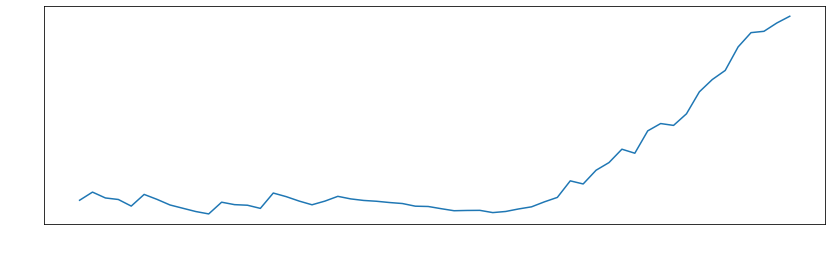

In [39]:
learn.recorder.plot()

### Train the model using differential learning rates by passing the max_lr argument to the fit_one_cycle method.

In [40]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.184295,0.126775,0.039427,09:12
1,0.276375,0.147388,0.046595,09:12
2,0.160508,0.054374,0.010753,09:10
3,0.087525,0.052762,0.014337,08:51


### SAVE the model for inference

In [0]:
learn.save('defect_classifier')

### Export Model

In [0]:
learn.load('defect_classifier')
learn.export('defect_classifier.pkl')

### Examine Confusion Matrix

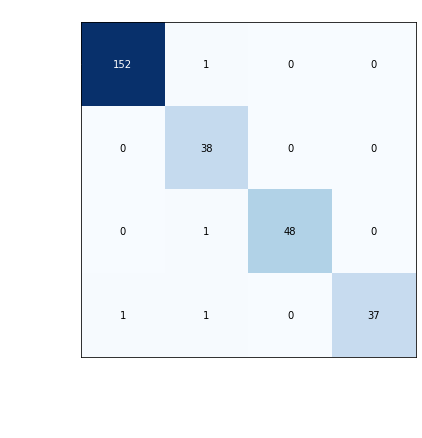

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))

### Create JSON file with new boards filenames

In [0]:
test_temps = {}
file_names = os.listdir('hold_out')

for index, file in enumerate(file_names):
  if "test" in file:
      test_temps[file_names[index]] = os.path.getsize('hold_out/' + file)

In [0]:
with open('test_temps.json', 'w') as outfile:
    json.dump(test_temps, outfile)

### Download hold out images to use with PCB Defect Classifier

In [0]:
# remove any files that are not JPG
!find hold_out -type f ! -name '*.jpg' -delete

zip_files_in_directory(**{
    "directory" : "hold_out/",
    "zip_filename" : "hold_out.zip"
})